In [4]:
import json
import math
import random
import os
import pickle as pkl
import time
from typing import Dict, List

import awkward as ak
import fastjet
import matplotlib
import matplotlib.pyplot as plt
import mplhep as hep
import numpy as np
import sklearn
import sklearn.metrics
import torch
import tqdm
import vector
from torch_geometric.data import Batch, Data

plt.style.use(hep.style.CMS)
plt.rcParams.update({"font.size": 20})

In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# import relevant functions from mlpf.pyg
import sys
sys.path.append("/home/jovyan/particleflow/mlpf/")
import pyg
sys.path.append("/home/jovyan/particleflow/mlpf/pyg/")
import utils

from PFDataset import PFDataset, PFDataLoader, Collater

from pyg.mlpf import MLPF
from pyg.utils import X_FEATURES, Y_FEATURES, unpack_predictions
from jet_utils import match_two_jet_collections

#################################### must update this function to have the proper p4
def unpack_target(y):
    ret = {}
    ret["cls_id"] = y[..., 0].long()
    ret["charge"] = torch.clamp((y[..., 1] + 1).to(dtype=torch.float32), 0, 2)  # -1, 0, 1 -> 0, 1, 2

    for i, feat in enumerate(Y_FEATURES):
        if i >= 2:  # skip the cls and charge as they are defined above
            ret[feat] = y[..., i].to(dtype=torch.float32)
    ret["phi"] = torch.atan2(ret["sin_phi"], ret["cos_phi"])

    # do some sanity checks
    # assert torch.all(ret["pt"] >= 0.0)  # pt
    # assert torch.all(torch.abs(ret["sin_phi"]) <= 1.0)  # sin_phi
    # assert torch.all(torch.abs(ret["cos_phi"]) <= 1.0)  # cos_phi
    # assert torch.all(ret["energy"] >= 0.0)  # energy

    # note ~ momentum = ["pt", "eta", "sin_phi", "cos_phi", "energy"]
    ret["momentum"] = y[..., 2:7].to(dtype=torch.float32)
    ret["p4"] = torch.cat(
        [ret["pt"].unsqueeze(-1), ret["eta"].unsqueeze(-1), ret["phi"].unsqueeze(-1), ret["energy"].unsqueeze(-1)], axis=-1
    )

    ret["genjet_idx"] = y[..., -1].long()

    return ret

In [7]:
# define the global base device
world_size = 1
if torch.cuda.device_count():
    rank = 0
    device = torch.device("cuda:0")
    print(f"Will use {torch.cuda.get_device_name(device)}")
else:
    rank = "cpu"
    device = "cpu"
    print("Will use cpu")

Will use NVIDIA A100-SXM4-80GB


# Load the pre-trained MLPF model

In [8]:
def load_checkpoint(checkpoint, model, optimizer=None):
    if isinstance(model, torch.nn.parallel.DistributedDataParallel):
        model.module.load_state_dict(checkpoint["model_state_dict"])
    else:
        model.load_state_dict(checkpoint["model_state_dict"])
    if optimizer:
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        return model, optimizer
    else:
        return model
    
    
loaddir = "/pfvol/experiments/MLPF_clic_A100_1gpu_pyg-clic_20240322_233518_004447"

with open(f"{loaddir}/model_kwargs.pkl", "rb") as f:
    mlpf_kwargs = pkl.load(f)

mlpf_kwargs["attention_type"] = "flash"

mlpf = MLPF(**mlpf_kwargs).to(torch.device(rank))
checkpoint = torch.load(f"{loaddir}/best_weights.pth", map_location=torch.device(rank))

mlpf = load_checkpoint(checkpoint, mlpf)
mlpf.eval()

print(mlpf)    

MLPF(
  (nn0): Sequential(
    (0): Linear(in_features=17, out_features=256, bias=True)
    (1): ELU(alpha=1.0)
    (2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (3): Dropout(p=0.0, inplace=False)
    (4): Linear(in_features=256, out_features=256, bias=True)
  )
  (conv_id): ModuleList(
    (0-2): 3 x SelfAttentionLayer(
      (mha): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (norm0): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (seq): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): ELU(alpha=1.0)
        (2): Linear(in_features=256, out_features=256, bias=True)
        (3): ELU(alpha=1.0)
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
  )
  (conv_reg): ModuleList(
    (0-2): 3 x SelfAttentionLayer(
      (mha): MultiheadAttention(
        (ou

# CLIC dataset

In [9]:
! ls /pfvol/tensorflow_datasets/

clic_edm_qq_pf		   cms_pf_qcd_high_pt	   cms_pf_single_proton
clic_edm_ttbar_pf	   cms_pf_single_electron  cms_pf_single_tau
clic_edm_ttbar_pu10_pf	   cms_pf_single_gamma	   cms_pf_sms_t1tttt
clic_edm_ww_fullhad_pf	   cms_pf_single_mu	   cms_pf_ttbar
clic_edm_zh_tautau_pf	   cms_pf_single_neutron   cms_pf_ztt
cms_pf_multi_particle_gun  cms_pf_single_pi	   delphes_qcd_pf
cms_pf_qcd		   cms_pf_single_pi0	   delphes_ttbar_pf


In [10]:
# we can see the 17th features here (recall type is 1 for tracks and 2 for clusters)
X_FEATURES["clic"]

['type',
 'pt | et',
 'eta',
 'sin_phi',
 'cos_phi',
 'p | energy',
 'chi2 | position.x',
 'ndf | position.y',
 'dEdx | position.z',
 'dEdxError | iTheta',
 'radiusOfInnermostHit | energy_ecal',
 'tanLambda | energy_hcal',
 'D0 | energy_other',
 'omega | num_hits',
 'Z0 | sigma_x',
 'time | sigma_y',
 'Null | sigma_z']

In [11]:
# we can see the 8 gen features per pf element here (notice the jet_index which may be useful)
Y_FEATURES

['cls_id', 'charge', 'pt', 'eta', 'sin_phi', 'cos_phi', 'energy']

# Load the dataset

In [13]:
! du -sh /pfvol/jetdataset/clic_edm_ttbar_pf/train/*

2.2G	/pfvol/jetdataset/clic_edm_ttbar_pf/train/0.pt
1.7G	/pfvol/jetdataset/clic_edm_ttbar_pf/train/10.pt
1.7G	/pfvol/jetdataset/clic_edm_ttbar_pf/train/11.pt
1.7G	/pfvol/jetdataset/clic_edm_ttbar_pf/train/12.pt
1.7G	/pfvol/jetdataset/clic_edm_ttbar_pf/train/13.pt
1.7G	/pfvol/jetdataset/clic_edm_ttbar_pf/train/14.pt
1.8G	/pfvol/jetdataset/clic_edm_ttbar_pf/train/15.pt
1.8G	/pfvol/jetdataset/clic_edm_ttbar_pf/train/16.pt
1.7G	/pfvol/jetdataset/clic_edm_ttbar_pf/train/17.pt
1.8G	/pfvol/jetdataset/clic_edm_ttbar_pf/train/18.pt
1.7G	/pfvol/jetdataset/clic_edm_ttbar_pf/train/19.pt
1.8G	/pfvol/jetdataset/clic_edm_ttbar_pf/train/1.pt
1.7G	/pfvol/jetdataset/clic_edm_ttbar_pf/train/20.pt
1.7G	/pfvol/jetdataset/clic_edm_ttbar_pf/train/21.pt
1.7G	/pfvol/jetdataset/clic_edm_ttbar_pf/train/22.pt
1.8G	/pfvol/jetdataset/clic_edm_ttbar_pf/train/23.pt
1.8G	/pfvol/jetdataset/clic_edm_ttbar_pf/train/24.pt
1.7G	/pfvol/jetdataset/clic_edm_ttbar_pf/train/25.pt
1.8G	/pfvol/jetdataset/clic_edm_ttbar_pf/train/2

In [14]:
jet_dataset_train = torch.load("/pfvol/jetdataset/clic_edm_ttbar_pf/train/0.pt")
jet_dataset_test = torch.load("/pfvol/jetdataset/clic_edm_ttbar_pf/train/1.pt")

# Build a DataLoader

In [15]:
# Define your custom collate function to add a batch key
def collate_fn(data_list):
    batch = Batch.from_data_list(data_list)
    
    batch_list = []
    for ijet, jet in enumerate(data_list):
        num_MLPFcands = len(jet["mlpfcands_momentum"])   # number of MLPFcands
        batch_list += [ijet] * num_MLPFcands

    batch.batch = torch.tensor(batch_list)
    
    return batch

In [16]:
batch_size = 100

train_list = torch.utils.data.DataLoader(jet_dataset_train[:1000], batch_size=batch_size, collate_fn=collate_fn)
test_list = torch.utils.data.DataLoader(jet_dataset_test[:300], batch_size=batch_size, collate_fn=collate_fn)

In [17]:
len(train_list) * batch_size

1000

In [18]:
len(test_list) * batch_size

300

In [19]:
for batch in train_list:
    break
batch.keys()

['reco_jet_energy',
 'mlpfcands_charge',
 'mlpfcands_momentum',
 'gen_jet_phi',
 'batch',
 'reco_jet_eta',
 'gen_jet_pt',
 'gen_jet_eta',
 'mlpfcands_pid',
 'gen_jet_energy',
 'reco_jet_phi',
 'mlpfcands_latentX',
 'gen_jet_label',
 'reco_jet_pt']

# Setup the downstream task

In [20]:
import torch.nn as nn
from torch_geometric.nn.pool import global_add_pool


def ffn(input_dim, output_dim, width, act, dropout):
    return nn.Sequential(
        nn.Linear(input_dim, width),
        act(),
        torch.nn.LayerNorm(width),
        nn.Dropout(dropout),
        nn.Linear(width, output_dim),
    )

class JetRegressor(nn.Module):
    def __init__(
        self,
        input_dim=14,
        embedding_dim=64,
        output_dim=1,
        width=256,
        dropout=0,
    ):
        super(JetRegressor, self).__init__()

        """
        Takes as input either (1) the MLPF candidates OR (2) the latent representations of the MLPF candidates,
        and runs an MLP to predict an output per jet: "ptcorr"; which will enter the loss as follows:
            pred_jetpt = ptcorr * reco_pt

            LOSS = Huber(true_jetpt, pred_jetpt)

        """

        self.act = nn.ELU
        self.nn1 = ffn(input_dim, embedding_dim, width, self.act, dropout)
        self.nn2 = ffn(embedding_dim, output_dim, width, self.act, dropout)

    # @torch.compile
    def forward(self, X, batch):

        embeddings = self.nn1(X)
        
#         pooled_embeddings = embeddings.sum(axis=1)   # recall ~ [Batch, Particles, Features]
    
        pooled_embeddings = global_add_pool(embeddings, batch)

        return self.nn2(pooled_embeddings)

In [21]:
run_with_latentX = True

if run_with_latentX:
    input_dim = 791
else:
    input_dim = 14    
    
model = JetRegressor(input_dim).to(rank)
model.train()

JetRegressor(
  (nn1): Sequential(
    (0): Linear(in_features=791, out_features=256, bias=True)
    (1): ELU(alpha=1.0)
    (2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (3): Dropout(p=0, inplace=False)
    (4): Linear(in_features=256, out_features=64, bias=True)
  )
  (nn2): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): ELU(alpha=1.0)
    (2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (3): Dropout(p=0, inplace=False)
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [22]:
for batch in train_list:

    batch = batch.to(rank)

    if run_with_latentX:
        X = batch["mlpfcands_latentX"]
    else:
        X = torch.cat([batch["mlpfcands_momentum"], batch["mlpfcands_pid"], batch["mlpfcands_charge"]], axis=-1)
    
    ptcorr = model(X, batch.batch).squeeze(1)
    
    target = torch.log(batch["gen_jet_pt"] / batch["reco_jet_pt"])

    loss = torch.nn.functional.huber_loss(target, ptcorr)
    
    break
print(loss)

tensor(0.2826, device='cuda:0', grad_fn=<HuberLossBackward0>)


# Training

In [23]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

In [24]:
# run training
num_epochs = 500

losses = {}
losses["train"], losses["valid"] = [], []
for epoch in range(num_epochs):
    
    ############################# train    
    model.train()            

    losses_t = 0
    for i, batch in enumerate(tqdm.tqdm(train_list)):
    
        batch = batch.to(rank)
        
        if run_with_latentX:
            X = batch["mlpfcands_latentX"]
        else:
            X = torch.cat([batch["mlpfcands_momentum"], batch["mlpfcands_pid"], batch["mlpfcands_charge"]], axis=-1)

        ptcorr = model(X, batch.batch).squeeze(1)

        target = torch.log(batch["gen_jet_pt"] / batch["reco_jet_pt"])
#         target = batch["gen_jet_pt"]

        loss = torch.nn.functional.huber_loss(target, ptcorr)

        for param in model.parameters():
            param.grad = None        
        loss.backward()
        optimizer.step()
        
        losses_t += loss

    train_loss = losses_t.detach().cpu().item() / len(train_list)
    
    losses["train"] += [train_loss]

    ############################# eval
    model.eval()            

    losses_v = 0
    for i, batch in enumerate(tqdm.tqdm(test_list)):
        batch = batch.to(rank)
        
        if run_with_latentX:
            X = batch["mlpfcands_latentX"]
        else:
            X = torch.cat([batch["mlpfcands_momentum"], batch["mlpfcands_pid"], batch["mlpfcands_charge"]], axis=-1)

        with torch.no_grad():            
            ptcorr = model(X, batch.batch).squeeze(1)

        target = torch.log(batch["gen_jet_pt"] / batch["reco_jet_pt"])
#         target = batch["gen_jet_pt"]

        with torch.no_grad():        
            loss = torch.nn.functional.huber_loss(target, ptcorr)

        losses_v += loss

    valid_loss = losses_v.detach().cpu().item() / len(test_list)
    
    losses["valid"] += [valid_loss]
    
    print(f"Epoch {epoch}: train_loss={train_loss:.4f} -  valid_loss={valid_loss:.4f}")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.47it/s]


Epoch 0: train_loss=0.0824 -  valid_loss=0.0148


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.88it/s]


Epoch 1: train_loss=0.0206 -  valid_loss=0.0070


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.05it/s]


Epoch 2: train_loss=0.0109 -  valid_loss=0.0066


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 10.55it/s]


Epoch 3: train_loss=0.0080 -  valid_loss=0.0051


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.36it/s]


Epoch 4: train_loss=0.0065 -  valid_loss=0.0049


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.73it/s]


Epoch 5: train_loss=0.0058 -  valid_loss=0.0047


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 14.24it/s]


Epoch 6: train_loss=0.0054 -  valid_loss=0.0046


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  9.76it/s]


Epoch 7: train_loss=0.0052 -  valid_loss=0.0044


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 14.29it/s]


Epoch 8: train_loss=0.0050 -  valid_loss=0.0044


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 10.30it/s]


Epoch 9: train_loss=0.0048 -  valid_loss=0.0043


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.90it/s]


Epoch 10: train_loss=0.0047 -  valid_loss=0.0042


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  5.12it/s]


Epoch 11: train_loss=0.0046 -  valid_loss=0.0042


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 10.05it/s]


Epoch 12: train_loss=0.0045 -  valid_loss=0.0042


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 15.01it/s]


Epoch 13: train_loss=0.0044 -  valid_loss=0.0042


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 15.82it/s]


Epoch 14: train_loss=0.0043 -  valid_loss=0.0042


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 15.42it/s]


Epoch 15: train_loss=0.0042 -  valid_loss=0.0042


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 14.35it/s]


Epoch 16: train_loss=0.0041 -  valid_loss=0.0042


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 14.83it/s]


Epoch 17: train_loss=0.0040 -  valid_loss=0.0042


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 13.59it/s]


Epoch 18: train_loss=0.0040 -  valid_loss=0.0042


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 14.71it/s]


Epoch 19: train_loss=0.0039 -  valid_loss=0.0042


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 15.16it/s]


Epoch 20: train_loss=0.0039 -  valid_loss=0.0042


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.47it/s]


Epoch 21: train_loss=0.0038 -  valid_loss=0.0042


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  5.07it/s]


Epoch 22: train_loss=0.0038 -  valid_loss=0.0042


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.32it/s]


Epoch 23: train_loss=0.0037 -  valid_loss=0.0042


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.00it/s]


Epoch 24: train_loss=0.0037 -  valid_loss=0.0042


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.32it/s]


Epoch 25: train_loss=0.0036 -  valid_loss=0.0042


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  5.05it/s]


Epoch 26: train_loss=0.0036 -  valid_loss=0.0042


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 26.27it/s]


Epoch 27: train_loss=0.0035 -  valid_loss=0.0042


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 26.92it/s]


Epoch 28: train_loss=0.0035 -  valid_loss=0.0042


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 13.89it/s]


Epoch 29: train_loss=0.0035 -  valid_loss=0.0042


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.50it/s]


Epoch 30: train_loss=0.0034 -  valid_loss=0.0043


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.37it/s]


Epoch 31: train_loss=0.0034 -  valid_loss=0.0043


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  9.97it/s]


Epoch 32: train_loss=0.0034 -  valid_loss=0.0043


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 14.02it/s]


Epoch 33: train_loss=0.0033 -  valid_loss=0.0043


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  9.88it/s]


Epoch 34: train_loss=0.0033 -  valid_loss=0.0043


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.31it/s]


Epoch 35: train_loss=0.0033 -  valid_loss=0.0043


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.02it/s]


Epoch 36: train_loss=0.0032 -  valid_loss=0.0043


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.73it/s]


Epoch 37: train_loss=0.0032 -  valid_loss=0.0043


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.70it/s]


Epoch 38: train_loss=0.0032 -  valid_loss=0.0044


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.16it/s]


Epoch 39: train_loss=0.0031 -  valid_loss=0.0044


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.64it/s]


Epoch 40: train_loss=0.0031 -  valid_loss=0.0044


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  9.83it/s]


Epoch 41: train_loss=0.0031 -  valid_loss=0.0044


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 14.32it/s]


Epoch 42: train_loss=0.0031 -  valid_loss=0.0044


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 15.05it/s]


Epoch 43: train_loss=0.0030 -  valid_loss=0.0044


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  9.76it/s]


Epoch 44: train_loss=0.0030 -  valid_loss=0.0044


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.46it/s]


Epoch 45: train_loss=0.0030 -  valid_loss=0.0044


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 13.95it/s]


Epoch 46: train_loss=0.0029 -  valid_loss=0.0045


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 10.28it/s]


Epoch 47: train_loss=0.0029 -  valid_loss=0.0045


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 15.55it/s]


Epoch 48: train_loss=0.0029 -  valid_loss=0.0045


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 15.45it/s]


Epoch 49: train_loss=0.0028 -  valid_loss=0.0045


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 15.50it/s]


Epoch 50: train_loss=0.0028 -  valid_loss=0.0045


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  9.90it/s]


Epoch 51: train_loss=0.0028 -  valid_loss=0.0045


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 10.05it/s]


Epoch 52: train_loss=0.0028 -  valid_loss=0.0045


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 15.43it/s]


Epoch 53: train_loss=0.0027 -  valid_loss=0.0045


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 15.41it/s]


Epoch 54: train_loss=0.0027 -  valid_loss=0.0045


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.99it/s]


Epoch 55: train_loss=0.0027 -  valid_loss=0.0045


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.43it/s]


Epoch 56: train_loss=0.0026 -  valid_loss=0.0045


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 13.72it/s]


Epoch 57: train_loss=0.0026 -  valid_loss=0.0045


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.01it/s]


Epoch 58: train_loss=0.0026 -  valid_loss=0.0045


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  5.05it/s]


Epoch 59: train_loss=0.0026 -  valid_loss=0.0045


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.99it/s]


Epoch 60: train_loss=0.0025 -  valid_loss=0.0045


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.98it/s]


Epoch 61: train_loss=0.0025 -  valid_loss=0.0045


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  9.51it/s]


Epoch 62: train_loss=0.0025 -  valid_loss=0.0045


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.00it/s]


Epoch 63: train_loss=0.0025 -  valid_loss=0.0045


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.59it/s]


Epoch 64: train_loss=0.0024 -  valid_loss=0.0045


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.31it/s]


Epoch 65: train_loss=0.0024 -  valid_loss=0.0045


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.04it/s]


Epoch 66: train_loss=0.0024 -  valid_loss=0.0045


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  5.85it/s]


Epoch 67: train_loss=0.0024 -  valid_loss=0.0045


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 14.46it/s]


Epoch 68: train_loss=0.0023 -  valid_loss=0.0045


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 14.09it/s]


Epoch 69: train_loss=0.0023 -  valid_loss=0.0045


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 10.09it/s]


Epoch 70: train_loss=0.0023 -  valid_loss=0.0045


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.60it/s]


Epoch 71: train_loss=0.0023 -  valid_loss=0.0045


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.64it/s]


Epoch 72: train_loss=0.0023 -  valid_loss=0.0045


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  9.90it/s]


Epoch 73: train_loss=0.0022 -  valid_loss=0.0045


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 14.47it/s]


Epoch 74: train_loss=0.0022 -  valid_loss=0.0045


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.54it/s]


Epoch 75: train_loss=0.0022 -  valid_loss=0.0046


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 26.89it/s]


Epoch 76: train_loss=0.0022 -  valid_loss=0.0046


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  9.66it/s]


Epoch 77: train_loss=0.0021 -  valid_loss=0.0046


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.99it/s]


Epoch 78: train_loss=0.0021 -  valid_loss=0.0046


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.43it/s]


Epoch 79: train_loss=0.0021 -  valid_loss=0.0046


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.61it/s]


Epoch 80: train_loss=0.0021 -  valid_loss=0.0046


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 14.72it/s]


Epoch 81: train_loss=0.0021 -  valid_loss=0.0046


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 10.45it/s]


Epoch 82: train_loss=0.0020 -  valid_loss=0.0046


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  5.05it/s]


Epoch 83: train_loss=0.0020 -  valid_loss=0.0046


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.53it/s]


Epoch 84: train_loss=0.0020 -  valid_loss=0.0046


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 26.99it/s]


Epoch 85: train_loss=0.0020 -  valid_loss=0.0046


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 14.17it/s]


Epoch 86: train_loss=0.0020 -  valid_loss=0.0046


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 27.57it/s]


Epoch 87: train_loss=0.0019 -  valid_loss=0.0046


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 10.29it/s]


Epoch 88: train_loss=0.0019 -  valid_loss=0.0047


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.35it/s]


Epoch 89: train_loss=0.0019 -  valid_loss=0.0047


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.35it/s]


Epoch 90: train_loss=0.0019 -  valid_loss=0.0047


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  9.54it/s]


Epoch 91: train_loss=0.0019 -  valid_loss=0.0047


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.53it/s]


Epoch 92: train_loss=0.0018 -  valid_loss=0.0047


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 14.62it/s]


Epoch 93: train_loss=0.0018 -  valid_loss=0.0047


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 10.27it/s]


Epoch 94: train_loss=0.0018 -  valid_loss=0.0047


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  5.97it/s]


Epoch 95: train_loss=0.0018 -  valid_loss=0.0047


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.39it/s]


Epoch 96: train_loss=0.0018 -  valid_loss=0.0047


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  9.73it/s]


Epoch 97: train_loss=0.0018 -  valid_loss=0.0047


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  9.80it/s]


Epoch 98: train_loss=0.0017 -  valid_loss=0.0047


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 14.32it/s]


Epoch 99: train_loss=0.0017 -  valid_loss=0.0047


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.39it/s]


Epoch 100: train_loss=0.0017 -  valid_loss=0.0047


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.24it/s]


Epoch 101: train_loss=0.0017 -  valid_loss=0.0047


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  9.73it/s]


Epoch 102: train_loss=0.0017 -  valid_loss=0.0047


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.62it/s]


Epoch 103: train_loss=0.0017 -  valid_loss=0.0047


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.05it/s]


Epoch 104: train_loss=0.0016 -  valid_loss=0.0047


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.02it/s]


Epoch 105: train_loss=0.0016 -  valid_loss=0.0048


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 14.46it/s]


Epoch 106: train_loss=0.0016 -  valid_loss=0.0048


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.05it/s]


Epoch 107: train_loss=0.0016 -  valid_loss=0.0048


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 10.16it/s]


Epoch 108: train_loss=0.0016 -  valid_loss=0.0048


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  9.66it/s]


Epoch 109: train_loss=0.0016 -  valid_loss=0.0048


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  5.85it/s]


Epoch 110: train_loss=0.0015 -  valid_loss=0.0048


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.29it/s]


Epoch 111: train_loss=0.0015 -  valid_loss=0.0048


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 14.42it/s]


Epoch 112: train_loss=0.0015 -  valid_loss=0.0048


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 15.35it/s]


Epoch 113: train_loss=0.0015 -  valid_loss=0.0048


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  9.90it/s]


Epoch 114: train_loss=0.0015 -  valid_loss=0.0048


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 15.47it/s]


Epoch 115: train_loss=0.0015 -  valid_loss=0.0048


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 16.05it/s]


Epoch 116: train_loss=0.0014 -  valid_loss=0.0048


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.36it/s]


Epoch 117: train_loss=0.0014 -  valid_loss=0.0049


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  9.74it/s]


Epoch 118: train_loss=0.0014 -  valid_loss=0.0049


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 10.45it/s]


Epoch 119: train_loss=0.0014 -  valid_loss=0.0049


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 10.13it/s]


Epoch 120: train_loss=0.0014 -  valid_loss=0.0049


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 14.75it/s]


Epoch 121: train_loss=0.0014 -  valid_loss=0.0049


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 16.49it/s]


Epoch 122: train_loss=0.0014 -  valid_loss=0.0049


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 10.54it/s]


Epoch 123: train_loss=0.0013 -  valid_loss=0.0049


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.81it/s]


Epoch 124: train_loss=0.0013 -  valid_loss=0.0049


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.04it/s]


Epoch 125: train_loss=0.0013 -  valid_loss=0.0049


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.99it/s]


Epoch 126: train_loss=0.0013 -  valid_loss=0.0050


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.69it/s]


Epoch 127: train_loss=0.0013 -  valid_loss=0.0050


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.71it/s]


Epoch 128: train_loss=0.0013 -  valid_loss=0.0050


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 27.17it/s]


Epoch 129: train_loss=0.0013 -  valid_loss=0.0050


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 14.67it/s]


Epoch 130: train_loss=0.0013 -  valid_loss=0.0050


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 14.54it/s]


Epoch 131: train_loss=0.0012 -  valid_loss=0.0050


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 10.40it/s]


Epoch 132: train_loss=0.0012 -  valid_loss=0.0050


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 26.98it/s]


Epoch 133: train_loss=0.0012 -  valid_loss=0.0051


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 25.17it/s]


Epoch 134: train_loss=0.0012 -  valid_loss=0.0051


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 14.72it/s]


Epoch 135: train_loss=0.0012 -  valid_loss=0.0051


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 10.32it/s]


Epoch 136: train_loss=0.0012 -  valid_loss=0.0051


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.73it/s]


Epoch 137: train_loss=0.0012 -  valid_loss=0.0051


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 10.09it/s]


Epoch 138: train_loss=0.0012 -  valid_loss=0.0051


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 15.43it/s]


Epoch 139: train_loss=0.0012 -  valid_loss=0.0052


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 15.09it/s]


Epoch 140: train_loss=0.0011 -  valid_loss=0.0052


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 10.02it/s]


Epoch 141: train_loss=0.0011 -  valid_loss=0.0052


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 15.74it/s]


Epoch 142: train_loss=0.0011 -  valid_loss=0.0052


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 26.32it/s]


Epoch 143: train_loss=0.0011 -  valid_loss=0.0052


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.47it/s]


Epoch 144: train_loss=0.0011 -  valid_loss=0.0052


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.04it/s]


Epoch 145: train_loss=0.0011 -  valid_loss=0.0053


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.05it/s]


Epoch 146: train_loss=0.0011 -  valid_loss=0.0053


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.49it/s]


Epoch 147: train_loss=0.0011 -  valid_loss=0.0053


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 14.68it/s]


Epoch 148: train_loss=0.0011 -  valid_loss=0.0053


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  9.82it/s]


Epoch 149: train_loss=0.0011 -  valid_loss=0.0053


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.28it/s]


Epoch 150: train_loss=0.0011 -  valid_loss=0.0053


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 15.24it/s]


Epoch 151: train_loss=0.0011 -  valid_loss=0.0054


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 13.87it/s]


Epoch 152: train_loss=0.0011 -  valid_loss=0.0054


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  9.94it/s]


Epoch 153: train_loss=0.0011 -  valid_loss=0.0054


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.70it/s]


Epoch 154: train_loss=0.0010 -  valid_loss=0.0054


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 10.08it/s]


Epoch 155: train_loss=0.0010 -  valid_loss=0.0054


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.25it/s]


Epoch 156: train_loss=0.0010 -  valid_loss=0.0054


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.08it/s]


Epoch 157: train_loss=0.0010 -  valid_loss=0.0054


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 14.14it/s]


Epoch 158: train_loss=0.0010 -  valid_loss=0.0054


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.05it/s]


Epoch 159: train_loss=0.0011 -  valid_loss=0.0054


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.98it/s]


Epoch 160: train_loss=0.0011 -  valid_loss=0.0054


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  5.09it/s]


Epoch 161: train_loss=0.0011 -  valid_loss=0.0054


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.02it/s]


Epoch 162: train_loss=0.0011 -  valid_loss=0.0055


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 26.33it/s]


Epoch 163: train_loss=0.0011 -  valid_loss=0.0055


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 10.14it/s]


Epoch 164: train_loss=0.0011 -  valid_loss=0.0055


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 14.60it/s]


Epoch 165: train_loss=0.0011 -  valid_loss=0.0055


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 13.81it/s]


Epoch 166: train_loss=0.0012 -  valid_loss=0.0055


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.25it/s]


Epoch 167: train_loss=0.0012 -  valid_loss=0.0055


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 15.08it/s]


Epoch 168: train_loss=0.0013 -  valid_loss=0.0055


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 14.20it/s]


Epoch 169: train_loss=0.0014 -  valid_loss=0.0056


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.47it/s]


Epoch 170: train_loss=0.0015 -  valid_loss=0.0057


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 28.72it/s]


Epoch 171: train_loss=0.0016 -  valid_loss=0.0060


 50%|█████████████████████████████████████████████████▌                                                 | 5/10 [00:00<00:00, 17.52it/s]

KeyboardInterrupt



Text(0, 1, 'Loss')

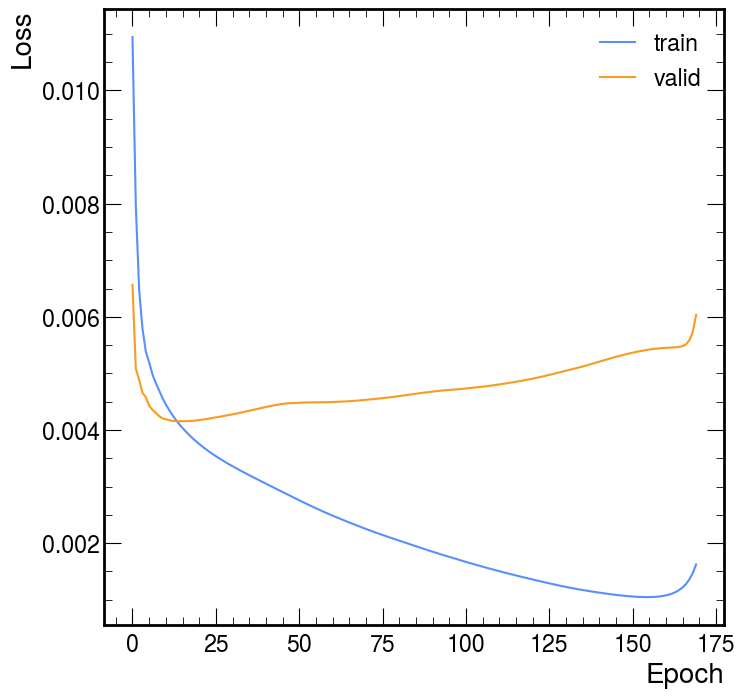

In [25]:
fig, ax = plt.subplots(figsize=(8,8))

ax.plot(losses["train"][2:], label="train")
ax.plot(losses["valid"][2:], label="valid")

ax.legend()
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")

In [ ]:
# run training
num_epochs = 500

losses = {}
losses["train"], losses["valid"] = [], []
for epoch in range(num_epochs):

    ############################# eval
    model.eval()            

    losses_v = 0
    for i, batch in enumerate(tqdm.tqdm(test_list)):
        batch = batch.to(rank)
        
        if run_with_latentX:
            X = batch["mlpfcands_latentX"]
        else:
            X = torch.cat([batch["mlpfcands_momentum"], batch["mlpfcands_pid"], batch["mlpfcands_charge"]], axis=-1)

        with torch.no_grad():            
            ptcorr = model(X, batch.batch).squeeze(1)

        target = torch.log(batch["gen_jet_pt"] / batch["reco_jet_pt"])
#         target = batch["gen_jet_pt"]

        with torch.no_grad():        
            loss = torch.nn.functional.huber_loss(target, ptcorr)

        losses_v += loss

    valid_loss = losses_v.detach().cpu().item() / len(test_list)
    
    losses["valid"] += [valid_loss]
    
    print(f"Epoch {epoch}: train_loss={train_loss:.4f} -  valid_loss={valid_loss:.4f}")

In [32]:
batch["gen_jet_pt"]

tensor([ 17.1507,  79.3878,  47.8966,  57.6023,  86.3188,  96.6546,  39.9496,
        100.8567,  41.5525,  43.4253, 103.1332,  28.1064,  50.3751,  44.6957,
         35.5974,  17.7281,  29.4926,  64.4847,  70.6352,  29.8314,  41.1940,
         43.1043,  47.1654,  69.8445,  42.2451,  95.4993,  83.6656, 122.0839,
         44.3346,  52.9785,  55.0933,  31.2192,  68.6183,  66.5174,  50.1306,
         43.3509,  63.7247,  59.1011,  56.5230,  58.3527,  38.8795,  73.9918,
         24.3210, 104.5304,  67.1446,  35.0238,  49.4356,  31.9582,  29.9008,
         23.6651,  66.7257,  63.7292,  37.6293,  23.7886,  64.4540,  31.9778,
         88.7153,  46.6671,  31.2063,  51.5697, 104.2345,  20.8037,  85.9316,
         94.5863,  26.0373,  61.2378,  42.2324,  81.6671,  45.6461,  89.1322,
         47.6147,  61.5233,  42.9962,  84.6362,  41.0061,  63.6443,  66.4212,
         64.0645,  23.0270,  43.5801,  92.3185,  28.9112,  40.9956,  63.0638,
         62.0721,  59.2450,  18.7583,  30.0468,  57.4143,  97.40

In [30]:
batch["reco_jet_pt"] * torch.exp(ptcorr)

tensor([ 17.6542,  78.7571,  47.5255,  60.7885,  88.8755,  91.8941,  41.0049,
        100.3029,  39.5748,  43.5890,  93.7299,  29.4473,  54.1175,  48.0685,
         35.7808,  18.1348,  31.0612,  61.6736,  70.4590,  31.0339,  36.1216,
         41.3599,  48.9947,  70.1730,  50.8246,  92.6759,  88.3744, 114.2119,
         44.6645,  42.9279,  60.9528,  32.1265,  70.9108,  60.4688,  48.7606,
         42.5559,  67.9962,  54.9468,  55.3293,  51.8393,  39.2976,  69.0080,
         23.3694, 103.1381,  63.4785,  35.8491,  54.0132,  30.5384,  29.0656,
         22.0230,  63.4085,  69.3850,  38.1683,  22.0723,  69.4621,  29.0088,
         82.5197,  42.4752,  31.6314,  53.7130,  89.8577,  16.5189,  86.7159,
         93.9434,  28.7931,  62.2996,  39.6813,  83.9001,  41.5254,  91.7704,
         45.3964,  64.5815,  40.8031,  77.2130,  42.7653,  61.8615,  60.4731,
         56.2560,  24.4905,  46.3739,  90.2834,  28.8223,  38.7702,  65.9372,
         64.1132,  60.4280,  20.9169,  29.8746,  57.8121,  88.18

In [33]:
batch["reco_jet_pt"]

tensor([ 17.5191,  79.5381,  46.7730,  55.5600,  83.8354,  95.5777,  34.5092,
         97.6328,  40.5641,  43.9620,  99.2788,  28.6839,  57.8821,  46.8246,
         34.7672,  16.9297,  29.9037,  61.8271,  63.8867,  30.2674,  40.7068,
         41.5637,  47.7119,  68.9880,  58.4492,  96.1004,  82.8112, 119.4390,
         43.6507,  48.2455,  53.9468,  30.8366,  69.7537,  67.5395,  50.1836,
         43.5388,  63.5720,  59.6706,  56.4835,  58.7481,  39.3866,  75.2741,
         24.3816, 100.5572,  64.3762,  44.3390,  54.6697,  29.9725,  30.0926,
         19.7844,  66.1060,  63.1669,  39.2697,  24.4862,  79.7877,  31.7616,
         88.6601,  42.3452,  32.2539,  51.4568, 106.1202,  15.9081,  86.2508,
         93.2083,  26.1892,  60.5672,  43.2614,  80.6893,  45.1226,  82.9981,
         48.8561,  64.7404,  41.0726,  85.1933,  41.7949,  59.6659,  66.0420,
         60.5581,  23.4843,  46.7583,  83.7418,  28.4153,  43.1818,  60.2017,
         63.7578,  97.3640,  29.4789,  30.1068,  56.6385,  82.97